# Some *tests* of the inner functionality of the whole dqn package

## (a) Testing unity ml-agents env wrapper

In [ ]:
import os
import sys
import numpy as np

from navigation.envs import mlagents

In [ ]:
# definitions for full paths to executables
EXEC_BANANA_PATH = os.path.join( os.getcwd(), 'executables/Banana_Linux/Banana.x86_64' )
# EXEC_BANANA_NOVIS_PATH = os.path.join( os.getcwd(), 'executables/Banana_Linux_NoVis/Banana.x86_64' )

In [ ]:
# initialize the environment
_env = mlagents.createDiscreteActionsEnv( EXEC_BANANA_PATH )
## _env = mlagents.createDiscreteActionsEnv( EXEC_BANANA_NOVIS_PATH )

In [ ]:
print( 'numActions: ', _env.numActions )
print( 'obsShape: ', _env.obsShape )

In [ ]:
_state = _env.reset( training = False )
print( '_state.shape: ', _state.shape )
print( '_state:' )
_raysState = _state[:-2].reshape( 7, -1 )
print( '_raysState: ' )
print( _raysState )
print( '\n' )

def process( state ) :
    return state[:-2].reshape( 7, -1 )

_f1 = np.array( [[0.,1.,0.,0.,2.4/13.4],
                 [0.,0.,1.,0.,9.8/13.4],
                 [0.,0.,1.,0.,10.8/13.4],
                 [1.,0.,0.,0.,6.0/13.4],
                 [1.,0.,0.,0.,2.1/13.4],
                 [0.,0.,1.,0.,7.1/13.4],
                 [0.,1.,0.,0.,1.3/13.4]] )

_f2 = np.array( [[0.,0.,1.,0.,7.3/13.4],
                 [0.,1.,0.,0.,6.0/13.4],
                 [1.,0.,0.,0.,1.7/13.4],
                 [0.,0.,0.,1.,0.],
                 [1.,0.,0.,0.,3.7/13.4],
                 [1.,0.,0.,0.,3.2/13.4],
                 [0.,0.,1.,0.,1.9/13.4]] )

print( 'ray-observations-shape: ', (35,) )
print( _f1 )
print( '\n' )

print( 'ray-observations-shape: ', (35,) )
print( _f2 )
print( '\n' )

In [ ]:
_raysState[:,[0,2,4]]

In [ ]:
_state = _env.reset( training = False )

while True :
    
    _action = np.random.randint( _env.numActions )
    _snext, _reward, _done, _ = _env.step( 2 )
    
    print( '#######################' )
    print( '_snext: ' )
    print( process( _snext ) )
    print( '_reward: ', _reward )
    print( '_done: ', _done )
    
    if _done :
        break



## Testing the sumtree data structure

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from navigation.dqn.utils import sumtree

In [2]:
smtree = sumtree.SumTree(8)

smtree.add( 'a', 3 )
smtree.add( 'b', 10 )
smtree.add( 'c', 12 )
smtree.add( 'd', 4 )
smtree.add( 'e', 1 )
smtree.add( 'f', 2 )
smtree.add( 'g', 8 )
smtree.add( 'h', 2 )

In [3]:
smtree.getNode(41.99999)

(14, 2.0, 'h')

In [4]:
print( 'arr-tree: ', smtree._tree )
print( 'data: ', smtree._data )

arr-tree:  [42. 29. 13. 13. 16.  3. 10.  3. 10. 12.  4.  1.  2.  8.  2.]
data:  ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h']


In [5]:
smtree = sumtree.SumTree(8)

smtree.add( 'a', 3 )
smtree.add( 'b', 10 )
smtree.add( 'c', 12 )
smtree.add( 'd', 4 )
smtree.add( 'e', 1 )
smtree.add( 'f', 2 )
smtree.add( 'g', 8 )

smtree.total()

40.0

In [6]:
smtree._tree

array([40., 29., 11., 13., 16.,  3.,  8.,  3., 10., 12.,  4.,  1.,  2.,
        8.,  0.])

In [7]:
smtree.getNode(39.87)

(13, 8.0, 'g')

### testing sampling method

In [8]:
_val = 42. * np.random.random()
_indx, _nodeval, _data = smtree.getNode( _val )
print( 'sampled (%s), with nodeval=%.2f and indx=%i, for value=%.2f' % ( _data, _nodeval, _indx, _val )  )

sampled (a), with nodeval=3.00 and indx=7, for value=0.40


### checking the probability distribution given by the node values

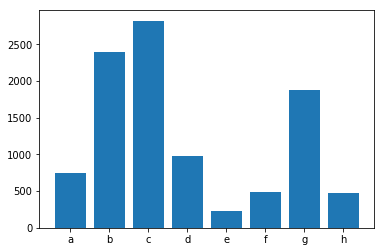

In [9]:
NSAMPLES = 10000
BUCKETS = [0] * len( smtree._data )
for _ in range( NSAMPLES ) :
    _indx, _, _data = smtree.getNode( 42. * np.random.random() )
    BUCKETS[_indx - len( smtree._data ) + 1] += 1
    
plt.bar( ['a','b','c','d','e','f','g','h'], BUCKETS )
plt.show()    

## Testing the priority buffer for Prioritized Exp. Replay

In [11]:
import numpy as np
from navigation.dqn.utils import prioritybuffer

pbuffer = prioritybuffer.DqnPriorityBuffer( 128, 0 )
pbuffer.add( [0.0, 1.0], 0, [0.1, 1.1], 0, False )

pbuffer._maxpriority

1.0

In [12]:
## see here, a warning due to non-zero division (it's taking min over all possible values in data buffer)
## have to fix by keeping the min somewhere else and updated, and then use it for this calculation
## one way: keep a variable for the running min (O(1) to grab, O(BatchSize) to update-> np.min->batch)
## another way: keep a mintree that will return the min value in O(log(n) + k)
_states, _actions, _nextStates, _rewards, _endflags, _indicesBatch, _isWeights = pbuffer.sample( 1 )

print( 'states: ', _states )
print( 'actions: ', _actions )
print( 'nextstates: ', _nextStates )
print( 'rewards: ', _rewards )
print( 'endflags: ', _endflags )
print( 'treeindices: ', _indicesBatch )
print( 'importance sampling weights: ', _isWeights )

states:  [[0. 1.]]
actions:  [0]
nextstates:  [[0.1 1.1]]
rewards:  [0]
endflags:  [0]
treeindices:  [127]
importance sampling weights:  [1.]


In [13]:
pbuffer.add( [0.2, 1.2], 1, [0.1, 1.1], 0, False )

In [14]:
_states, _actions, _nextStates, _rewards, _endflags, _indicesBatch, _isWeights = pbuffer.sample( 1 )

print( 'states: ', _states )
print( 'actions: ', _actions )
print( 'nextstates: ', _nextStates )
print( 'rewards: ', _rewards )
print( 'endflags: ', _endflags )
print( 'treeindices: ', _indicesBatch )
print( 'importance sampling weights: ', _isWeights )

states:  [[0.2 1.2]]
actions:  [1]
nextstates:  [[0.1 1.1]]
rewards:  [0]
endflags:  [0]
treeindices:  [128]
importance sampling weights:  [1.]


In [15]:
pbuffer.updatePriorities( np.array( [128] ), np.array( [100.] ) )

In [16]:
_states, _actions, _nextStates, _rewards, _endflags, _indicesBatch, _isWeights = pbuffer.sample( 1 )

print( 'states: ', _states )
print( 'actions: ', _actions )
print( 'nextstates: ', _nextStates )
print( 'rewards: ', _rewards )
print( 'endflags: ', _endflags )
print( 'treeindices: ', _indicesBatch )
print( 'importance sampling weights: ', _isWeights )

states:  [[0.2 1.2]]
actions:  [1]
nextstates:  [[0.1 1.1]]
rewards:  [0]
endflags:  [0]
treeindices:  [128]
importance sampling weights:  [0.33110487]


In [17]:
pbuffer._maxpriority

15.84988284150878

## Testing segmentrees from various implementations

* Adaptation from openai-baselines + other sources
* OpenAI-baselines

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from navigation.dqn.utils import sumtree
from navigation.dqn.utils import segmentree

In [19]:
smtree1 = sumtree.SumTree(8)
smtree2 = segmentree.SumTree(8)

_nodevals = { 'a' : 3, 'b' : 10, 'c' : 12, 'd' : 4, 'e' : 1, 'f' : 2, 'g' : 8 }

for key in _nodevals.keys() :
    smtree1.add( key, _nodevals[key] )
    smtree2.add( key, _nodevals[key] )


In [20]:
smtree1.total()

40.0

In [21]:
smtree2.sum()

40.0

In [22]:
smtree2.getNode(40.999998888)

(13, 8.0, 'g')

### checking update functionality

In [23]:
# data, tree and sum before the update
print( 'data: ', smtree2._data  )
print( 'tree: ', smtree2._tree )
print( 'sum: ', smtree2.sum() )

# do an update (change 'a' from nodeval 3 to nodeval 5)
smtree2.update( 7, 5 )

# data, tree and sum after the update
print( 'data: ', smtree2._data  )
print( 'tree: ', smtree2._tree )
print( 'sum: ', smtree2.sum() )

data:  ['a' 'b' 'c' 'd' 'e' 'f' 'g' 0]
tree:  [40. 29. 11. 13. 16.  3.  8.  3. 10. 12.  4.  1.  2.  8.  0.]
sum:  40.0
data:  ['a' 'b' 'c' 'd' 'e' 'f' 'g' 0]
tree:  [42. 31. 11. 15. 16.  3.  8.  5. 10. 12.  4.  1.  2.  8.  0.]
sum:  42.0


### checking the probability distribution generated from both

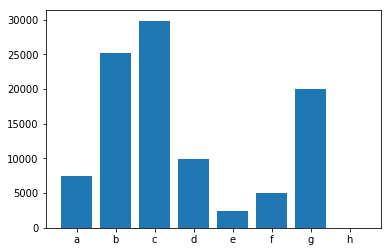

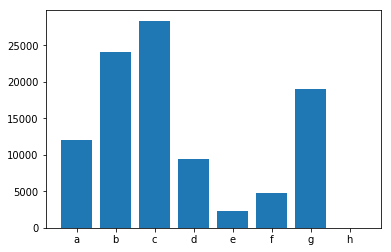

In [24]:
NSAMPLES = 100000
BUCKETS1 = [0] * len( smtree1._data )
BUCKETS2 = [0] * len( smtree2._data )
for _ in range( NSAMPLES ) :
    _rnd = np.random.random()
    
    _indx, _, _data = smtree1.getNode( smtree1.total() * _rnd )
    BUCKETS1[_indx - len( smtree1._data ) + 1] += 1
    
    _indx, _, _data = smtree2.getNode( smtree2.sum() * _rnd )
    BUCKETS2[_indx - len( smtree2._data ) + 1] += 1
    
fig1, ax1 = plt.subplots()
ax1.bar( ['a','b','c','d','e','f','g','h'], BUCKETS1 )

fig2, ax2 = plt.subplots()
ax2.bar( ['a','b','c','d','e','f','g','h'], BUCKETS2 )
plt.show()    

### testing the mintree

In [25]:
mintree = segmentree.MinTree(8)
mintree.add( 'a', 1 )
mintree.add( 'b', 3 )
mintree.add( 'c', 5 )
mintree.add( 'd', 0 )

print( 'min: ', mintree.min() )

mintree.add( 'e', -1 )

print( 'min: ', mintree.min() )

mintree.add( 'f', 10 )

print( 'min: ', mintree.min() )

min:  0.0
min:  -1.0
min:  -1.0


### testing openai-baselines segmentree

In [26]:
from navigation.dqn.utils import openai_segmentree as op_segmentree

In [27]:
# a simple test case
smtree3 = op_segmentree.SumSegmentTree(8)

smtree3[0] = 3
smtree3[1] = 10
smtree3[2] = 12
smtree3[3] = 4
smtree3[4] = 1
smtree3[5] = 2
smtree3[6] = 8
smtree3[7] = 2

print( 'sum: ', smtree3.sum() )

sum:  42


In [28]:
_sum1 = smtree1.total()
_sum2 = smtree2.sum()
_sum3 = smtree3.sum()

assert (_sum1 == _sum2) and (_sum2 == _sum3), 'ERROR> sumtrees should return same total cumsum'

_nodeval = _sum1 * np.random.random()

_indx1, _, _ = smtree1.getNode( _nodeval )
_indx2, _, _ = smtree2.getNode( _nodeval )
_indx3 = smtree3.find_prefixsum_idx( _nodeval ) + smtree3._capacity - 1

print( 'indx1: ', _indx1 )
print( 'indx2: ', _indx2 )
print( 'indx3: ', _indx3 )

AssertionError: ERROR> sumtrees should return same total cumsum

## Testing image conversion (rgb->hsv)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import rgb_to_hsv
from matplotlib.colors import hsv_to_rgb

In [ ]:
## let's use a simple image with pure r,g or b color
N = 5

# pure channels of NxN
_allOn   = np.ones( (N,N) )
_allOff = np.zeros( (N,N) )

# create the images themselves (tranpose them to (h,w,d) for matplotlib)
_redRgbImage   = np.transpose( np.stack( [_allOn, _allOff, _allOff] ), (1,2,0) )
_greenRgbImage = np.transpose( np.stack( [_allOff, _allOn, _allOff] ), (1,2,0) )
_blueRgbImage  = np.transpose( np.stack( [_allOff, _allOff, _allOn] ), (1,2,0) )
_blackRgbImage = np.transpose( np.stack( [_allOff, _allOff, _allOff] ), (1,2,0) )
_whiteRgbImage = np.transpose( np.stack( [_allOn, _allOn, _allOn] ), (1,2,0) )

print( 'checking images dtype and shape -----------------' )
print( 'red.shape   : ', _redRgbImage.shape )
print( 'green.shape : ', _greenRgbImage.shape )
print( 'blue.shape  : ', _blueRgbImage.shape )
print( 'black.shape : ', _blackRgbImage.shape )
print( 'white.shape : ', _whiteRgbImage.shape )

print( 'red.shape   : ', _redRgbImage.dtype )
print( 'green.shape : ', _greenRgbImage.dtype )
print( 'blue.shape  : ', _blueRgbImage.dtype )
print( 'black.shape : ', _blackRgbImage.dtype )
print( 'white.shape : ', _whiteRgbImage.dtype )
print( '-------------------------------------------------' )

plt.grid( False )

plt.subplot(151)
plt.imshow( _redRgbImage )

plt.subplot(152)
plt.imshow( _greenRgbImage )

plt.subplot(153)
plt.imshow( _blueRgbImage )

plt.subplot(154)
plt.imshow( _blackRgbImage )

plt.subplot(155)
plt.imshow( _whiteRgbImage )

In [ ]:
# convert to hsv
_redHsvImage    = rgb_to_hsv( _redRgbImage )
_greenHsvImage  = rgb_to_hsv( _greenRgbImage )
_blueHsvImage   = rgb_to_hsv( _blueRgbImage )
_blackHsvImage  = rgb_to_hsv( _blackRgbImage )
_whiteHsvImage = rgb_to_hsv( _whiteRgbImage )

print( _redHsvImage[...,0] )
print( _greenHsvImage[...,0] )
print( _blueHsvImage[...,0] )
print( _blackHsvImage[...,0] )
print( _whiteHsvImage[...,0] )

print( _redHsvImage[...,0].shape )

plt.subplot(151)
plt.imshow( _redHsvImage[...,0], cmap = 'gray', vmin = 0., vmax = 1. )

plt.subplot(152)
plt.imshow( _greenHsvImage[...,0], cmap = 'gray', vmin = 0., vmax = 1. )

plt.subplot(153)
plt.imshow( _blueHsvImage[...,0], cmap = 'gray', vmin = 0., vmax = 1. )

plt.subplot(154)
plt.imshow( _blackHsvImage[...,0], cmap = 'gray', vmin = 0., vmax = 1. )

plt.subplot(155)
plt.imshow( _whiteHsvImage[...,0], cmap = 'gray', vmin = 0., vmax = 1. )

## Testing the visual-banana environment

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from matplotlib.colors import rgb_to_hsv
from navigation.envs import mlagents

In [ ]:
# visual-banana executable path
EXEC_VISUAL_BANANA_PATH = os.path.join( os.getcwd(), 'executables/VisualBanana/VisualBanana.x86_64' )

In [ ]:
# initialize the environment and analyze it a bit
_env = mlagents.createDiscreteActionsEnv( EXEC_VISUAL_BANANA_PATH, envType = 'visual', workerID = 0 )

In [ ]:
# analyze some info from the environment
print( 'observation space shape: ', _env.obsShape )
print( 'number of actions: ', _env.numActions )

In [ ]:
# reset the environment and check the observations
_state = _env.reset( training = False )

print( 'type(state) : ', type(_state) )
print( 'state.shape : ', _state.shape )
print( 'state.dtype : ', _state.dtype )
print( 'state.max   : ', np.max( _state ) )
print( 'state.min   : ', np.min( _state ) )

In [ ]:
# run the environment for an episode
for _ in tqdm( range( 1000 ) ) :
    _state = _env.reset( training = True )
    
    while True :
    
        _action = np.random.randint( _env.numActions )
        _snext, _reward, _done, _ = _env.step( 0 )
    
        if _done :
            break

### checking the hsv conversion on the observations

In [ ]:
_state = _env.reset( training = False )
_hsvState = rgb_to_hsv( np.transpose( _state, (1,2,0) ) )

def rgb2gray(rgb):
    return 0.299 * rgb[0,...] + 0.587 * rgb[1,...] + 0.114 * rgb[2,...]

_grayState = rgb2gray(_state)
print( 'graystate.shape: ', _grayState.shape )
print( _grayState[2] )

plt.figure( figsize=(15,15) )
plt.subplot(151)
plt.imshow( np.transpose( _state, (1,2,0) ) )
plt.title( 'rgb-original' )

plt.subplot(152)
plt.imshow( _hsvState[...,0], cmap = 'gray', vmin = 0., vmax = 1. )
plt.title( 'hue-channel' )

plt.subplot(153)
plt.imshow( _hsvState[...,1], cmap = 'gray', vmin = 0., vmax = 1. )
plt.title( 'saturation-channel' )

plt.subplot(154)
plt.imshow( _hsvState[...,2], cmap = 'gray', vmin = 0., vmax = 1. )
plt.title( 'value-channel' )

plt.subplot(155)
plt.imshow( _grayState, cmap = 'gray', vmin = 0., vmax = 1. )
plt.title( 'grayscale' )